In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging
from IPython.display import display, Math
from astropy import units as u
from scipy.optimize import curve_fit

from mcmc_reg import PiecewiseConstSpectralModel, run_mcmc_with_reg, plot_corner, plot_trace, get_dnde
from gammapy.datasets import SpectrumDatasetOnOff
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel, Models
from gammapy.modeling import Fit


In [2]:
# Detailed reduction process can be found in data_reduction/data_reduction_geminga.ipynb
# Here use the stacked (averaged IRFs) dataset
dataset00 = SpectrumDatasetOnOff.read("../Dataset_reduced/GemingaP2_dataset00_stacked.fits")

# Spectrum fitting (Power-law)

In [3]:
# Initialize the model # pwl fit (the fitted amplitude will be set to the stepped pwl model)
spectral_model = PowerLawSpectralModel(
    amplitude=1e-9 * u.Unit("cm-2 s-1 TeV-1"),
    index=5,
    reference=32.15 * u.GeV,
)
model = SkyModel(spectral_model=spectral_model, name="gemingaP2_pwl")
dataset00.models = [model]

fit_pwl=Fit()
result_pwl = fit_pwl.run(datasets=dataset00)
model_pwl = model.copy()

print(result_pwl)
display(result_pwl.models.to_parameters_table())

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 71
	total stat : 17.26

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



model,type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str13,str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
gemingaP2_pwl,,index,5.1320e+00,,4.241e-01,nan,nan,False,False,,
gemingaP2_pwl,,amplitude,2.4881e-09,TeV-1 s-1 cm-2,6.176e-10,nan,nan,False,True,,
gemingaP2_pwl,,reference,3.2150e+01,GeV,0.000e+00,nan,nan,True,False,,


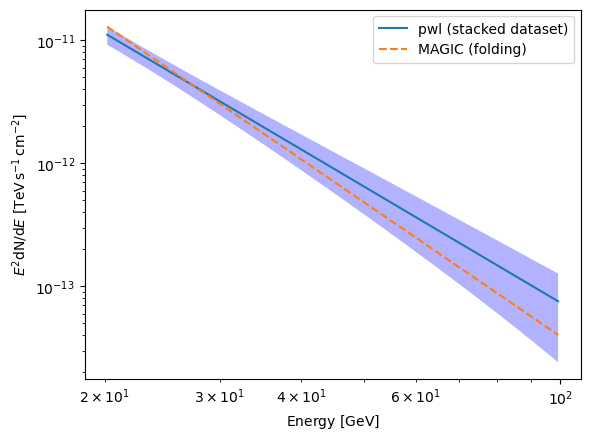

In [4]:
fig, ax = plt.subplots()
plot_kwargs = {
    "energy_bounds": [20, 100] * u.GeV,
    "sed_type": "e2dnde",
    "yunits": u.Unit("TeV cm-2 s-1"),
    "ax": ax,
}

# MAGIC collaboration et al 2020
performance_paper=PowerLawSpectralModel(
    amplitude= 2.3e-9*u.Unit("TeV-1 cm-2 s-1"),
    reference= 32.15*u.GeV,
    index = 5.62,
)
performance_paper.parameters['index'].error = 0.54
performance_paper.parameters['amplitude'].error = 0.7e-9

model_pwl.spectral_model.plot(**plot_kwargs, label="pwl (stacked dataset)")
model_pwl.spectral_model.plot_error(**plot_kwargs, facecolor="blue", alpha=0.3)
performance_paper.plot(**plot_kwargs, ls='--', label="MAGIC (folding)")
plt.ylabel(r"$E^2$dN/d$E$ $\mathrm{[TeV \, s^{-1} \, cm^{-2}]}$")
plt.legend()

# Stepped pwl model for flux estimation

The differential flux in the **$i$-th true energy bin** is
$$ \phi_i(E) = \mathrm{norm}_i \cdot f_0 \cdot \left(\frac{E}{E_0} \right)^{-2} $$

$E_0$ is the reference energy

$f_0$ is the reference flux, which can be set to the previous best-fit value

$\mathrm{norm}_i$ is the corresponding **free normalization parameter**, which is an estimate of the flux point.

In [5]:
# True energy axis
eval = dataset00.evaluators['gemingaP2_pwl']
true_ene_edges = eval.geom.axes["energy_true"].edges

true_ene_cntr = []
for emin, emax in list(zip(true_ene_edges[:-1], true_ene_edges[1:])):
    ecntr = np.sqrt(emin*emax)
    true_ene_cntr.append(ecntr)

true_ene_cntr = u.Quantity(true_ene_cntr)

print(f"True E edges:\n {true_ene_edges}")
print(f"True E centers:\n {true_ene_cntr}")

True E edges:
 [5.00000000e+00 7.75257890e+00 1.20204959e+01 1.86379686e+01
 2.88984644e+01 4.48075251e+01 6.94747747e+01 1.07721735e+02
 1.67024249e+02 2.58973734e+02 4.01542861e+02 6.22598542e+02
 9.65348864e+02 1.49678865e+03 2.32079442e+03 3.59842837e+03
 5.57941996e+03 8.65097869e+03 1.34134790e+04 2.07978108e+04
 3.22473339e+04 5.00000000e+04] GeV
True E centers:
 [6.22598542e+00 9.65348864e+00 1.49678865e+01 2.32079442e+01
 3.59842837e+01 5.57941996e+01 8.65097869e+01 1.34134790e+02
 2.07978108e+02 3.22473339e+02 5.00000000e+02 7.75257890e+02
 1.20204959e+03 1.86379686e+03 2.88984644e+03 4.48075251e+03
 6.94747747e+03 1.07721735e+04 1.67024249e+04 2.58973734e+04
 4.01542861e+04] GeV


In [6]:
# Stepped pwl model
source_amp = model_pwl.copy().spectral_model.amplitude
spectral_model = PowerLawSpectralModel(index=2.0, amplitude=source_amp, reference=32.15*u.GeV)
spectral_model.index.frozen = True
spectral_model.amplitude.frozen = True

Piecewise_const = PiecewiseConstSpectralModel(energy_edges = true_ene_edges)

# selecting an energy range that covers bins with significant excess counts
for idx in range(len(true_ene_cntr)):
    Piecewise_const.parameters['norm_%i'%idx].min = 1e-3
    Piecewise_const.parameters['norm_%i'%idx].max = 1e+2
    
    if true_ene_edges[:-1][idx] < 12*u.GeV :
        Piecewise_const.parameters['norm_%i'%idx].value = 0
        Piecewise_const.parameters['norm_%i'%idx].frozen = True
    if true_ene_edges[1:][idx] > 100*u.GeV :
        Piecewise_const.parameters['norm_%i'%idx].value = 0
        Piecewise_const.parameters['norm_%i'%idx].frozen = True
        

test_source = SkyModel(
    spectral_model  = spectral_model * Piecewise_const,
    name="test_source",
)

models = [test_source]
models = Models(models)
dataset00.models = models

# try minuit fitting for comparison
fit_stepped_pwl = Fit(backend='minuit')
result_stepped_pwl = fit_stepped_pwl.run(datasets = dataset00)

print(result_stepped_pwl)
print(test_source.spectral_model)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 195
	total stat : 16.64

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

CompoundSpectralModel
    Component 1 : PowerLawSpectralModel

type    name     value         unit        error   min max frozen is_norm link prior
---- --------- ---------- -------------- --------- --- --- ------ ------- ---- -----
         index 2.0000e+00                0.000e+00 nan nan   True   False           
     amplitude 2.4881e-09 TeV-1 s-1 cm-2 0.000e+00 nan nan   True    True           
     reference 3.2150e+01            GeV 0.000e+00 nan nan   True   False           
    Component 2 : PiecewiseConstSpectralModel

type   name    value    unit   error      min       max    frozen is_norm link prior
---- ------- ---------- ---- --------- --------- --------- ------ ------- ---- -----
   

Text(0, 0.5, 'dN/d$E$ $\\mathrm{[TeV^{-1} \\, s^{-1} \\, cm^{-2}]}$')

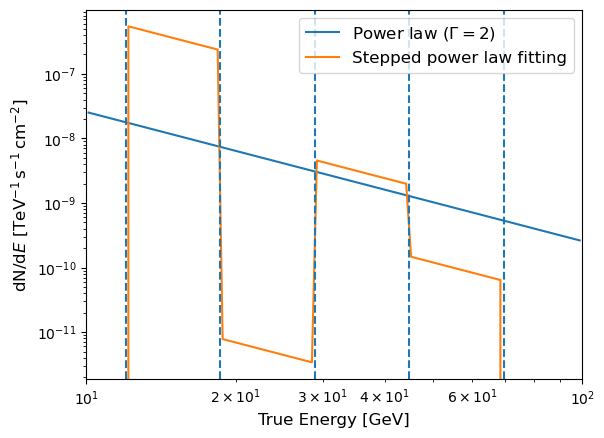

In [7]:
fig, ax = plt.subplots()
energy_bounds = [10, 100] * u.GeV

# a reference pwl model with fixed index = 2 (for illustration)
pwl_ref = PowerLawSpectralModel(amplitude= source_amp, index= 2, reference=32.15 * u.GeV)

pwl_ref.plot(energy_bounds, label='Power law ($\Gamma = 2$)')
test_source.spectral_model.plot(energy_bounds, label='Stepped power law fitting')

for en in true_ene_edges:
    plt.axvline(x=en, linestyle="--")

plt.xlim(energy_bounds)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12)
ax.set_xlabel("True Energy [GeV]", fontsize=12)
ax.set_ylabel("dN/d$E$ $\mathrm{[TeV^{-1} \, s^{-1} \, cm^{-2}]}$", fontsize=12)

### SED points

maximum likelihood fitting of the stepped pwl model

In [8]:
dnde_arr_fit = []
dnde_error_arr_fit = []

for emin,emax in list(zip(true_ene_edges[:-1], true_ene_edges[1:])):
    dnde, dnde_err = test_source.spectral_model.evaluate_error(np.sqrt(emin*emax))
    dnde_arr_fit.append(dnde)
    dnde_error_arr_fit.append(dnde_err)
dnde_arr_fit = u.Quantity(dnde_arr_fit)
dnde_error_arr_fit = u.Quantity(dnde_error_arr_fit)

In [9]:
ene_err_lower = true_ene_cntr - true_ene_edges[:-1]
ene_err_upper = true_ene_edges[1:] - true_ene_cntr

In [10]:
# Table 6.3: MAGIC Geminga spectral points obtained with the unfolding procedure
# Unit("GeV")
E_low = np.array([12.9, 20.1, 31.1, 48.3])
E_mid = np.array([16.0, 24.8, 38.4, 59.5])
E_up = np.array([20.1, 31.1, 48.3, 74.8])

# Unit("cm-2 s-1 TeV-1")
SED = np.array([24.4, 5.80, 1.51, 0.43]) * 1e-12
SED_err = np.array([6.7, 1.79, 0.51, 0.25]) * 1e-12

# SED / E**2
dnde_ref = np.array([24.4, 5.80, 1.51, 0.43]) * 1e-12 / (E_mid*1e-3)**2
dnde_ref_err =  np.array([6.7, 1.79, 0.51, 0.25]) * 1e-12 / (E_mid*1e-3)**2

E_err_lower = E_mid - E_low
E_err_upper = E_up - E_mid
E_err = [E_err_lower, E_err_upper]

Text(0, 0.5, '$E^2$dN/d$E$ $\\mathrm{[TeV \\, s^{-1} \\, cm^{-2}]}$')

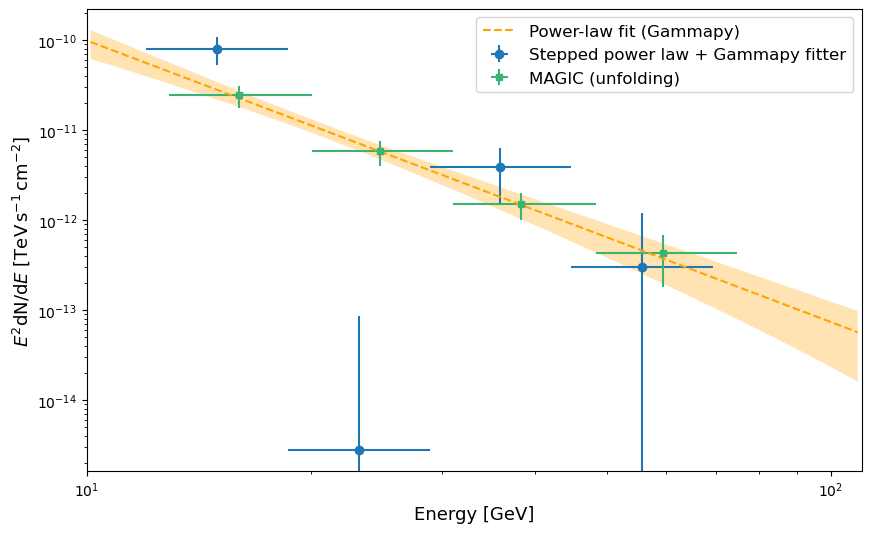

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.errorbar(true_ene_cntr, dnde_arr_fit * true_ene_cntr.to(u.TeV)**2, xerr=[ene_err_lower, ene_err_upper], yerr=dnde_error_arr_fit * true_ene_cntr.to(u.TeV)**2, fmt='o', label='Stepped power law + Gammapy fitter')

plt.errorbar(E_mid, SED, xerr=E_err, yerr=SED_err, capsize=0, fmt='s', color='mediumseagreen', markersize=4, label='MAGIC (unfolding)')

plot_kwargs = {
    "energy_bounds": [10, 110] * u.GeV,
    "sed_type": "e2dnde",
    "yunits": u.Unit("TeV cm-2 s-1"),
    "ax": ax,
}

model_pwl.spectral_model.plot(**plot_kwargs, color='orange',ls='--',label="Power-law fit (Gammapy)")
model_pwl.spectral_model.plot_error(**plot_kwargs, facecolor="orange", alpha=0.3)

energy_bounds = [10, 110] # * u.GeV
ax.set_xlim(energy_bounds)

plt.loglog()
plt.legend(fontsize=12)
plt.xlabel("Energy [GeV]", fontsize=13)
plt.ylabel(r"$E^2$dN/d$E$ $\mathrm{[TeV \, s^{-1} \, cm^{-2}]}$", fontsize=13)

### Note 

The large uncertainties and the up-and-down pattern comes from the ill-posed nature of the problem

# Run mcmc without regularization

In [12]:
%%time
sampler0 = run_mcmc_with_reg(dataset00, nwalkers=12, nrun=10000, threads=1, reg_depth=0, backend=None)

/home/iwsatlas1/yunhe/miniconda3/envs/gammapy-1.2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


CPU times: user 9min 55s, sys: 214 ms, total: 9min 55s
Wall time: 9min 55s


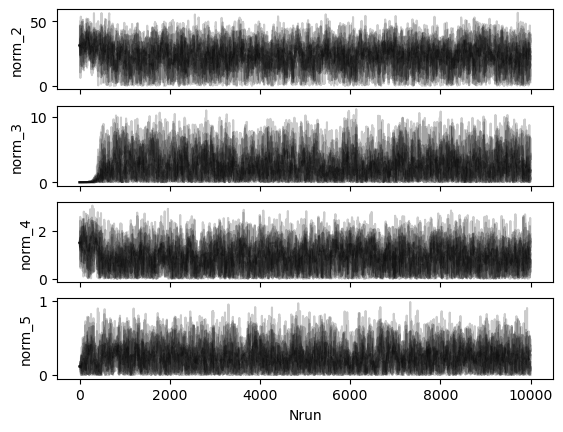

In [13]:
plot_trace(sampler0, dataset00)

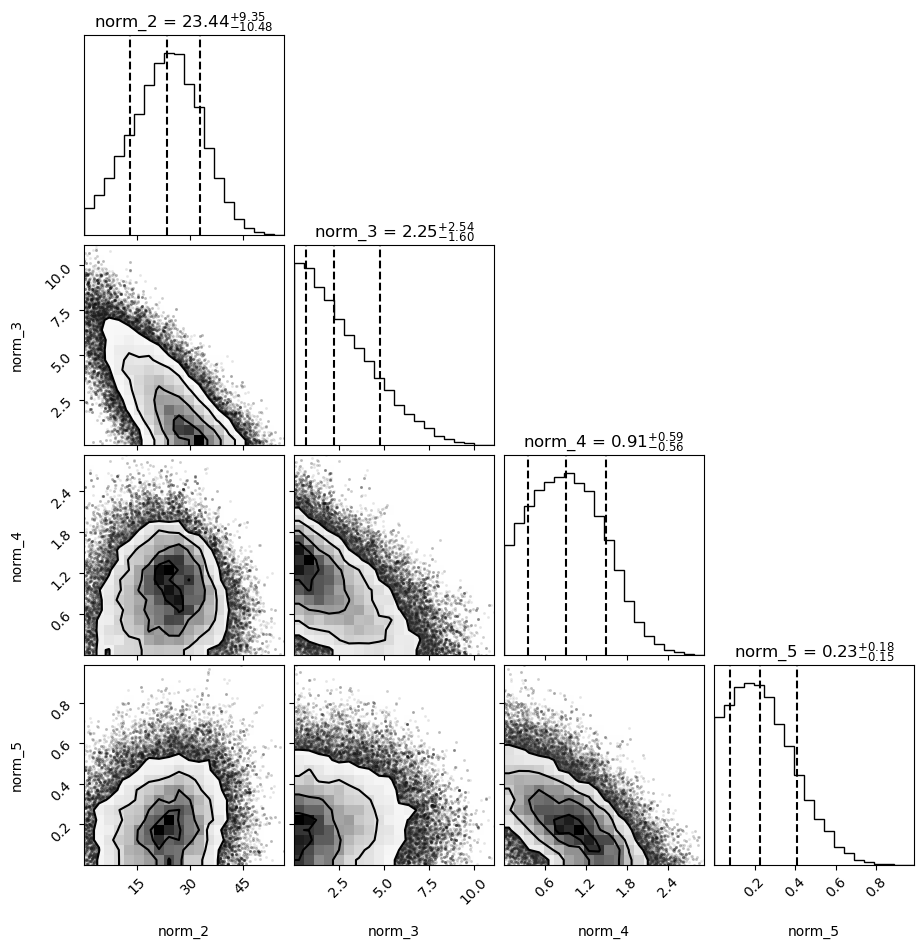

In [14]:
nburn = 1000
plot_corner(sampler0, dataset00, nburn)

### Note

the estimation from the 16\% and 84\% percentiles of the samples in the standard MCMC without regularization is actually **biased**.

If we fit the 1D distribution to a Gaussian distribution, we will obtain a much smaller mean and a much larger standard deviation. In this case, the SED estimation will be the **same as the results from Gammapy Fitter** (influenced by the ill-posed nature of the problem)


# Implementation of MCMC sampling with Tikhonov regularization

### Calculation of the Tikhonov regularization

1. Calculate predicted counts in true energy bins via forward-folding

- Computes the flux for the given true energy bins: `dataset.evaluator.compute_flux_spectral()`
  
- Applies the exposure to the flux map to compute npred: `dataset.evaluator..apply_exposure(flux)`

In [18]:
from mcmc_reg import get_npred_Etrue
B_arr = get_npred_Etrue(dataset00)
print(B_arr)

[   0.            0.         1059.5151191   494.43586617  554.54955647
  219.78488464    0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.        ]


2. Calculate the Tikhonov regularization term for given reg. depth $\lambda$

\begin{equation}
   \lambda R(B) = \lambda \| \frac{d^2 \ln B }{dx^2} \|^2 = \lambda \sum_{j=2}^{n_b-1}  \left[ 2 \cdot \left(\frac{B_{j+1} - B_j}{B_{j+1} + B_j} - \frac{B_{j} - B_{j-1}}{B_{j} + B_{j-1}}\right) \right]^2 \ .
\end{equation}

In [19]:
from mcmc_reg import compute_reg
reg_term = compute_reg(B_arr, reg_depth=1)
reg_term

1.6677437202625822

### Determine the optimal regularization depth $\lambda_{\mathrm{opt}}$

**Criterion**
\begin{equation}
    Tr(\mathbf{C_A}) = Tr(\mathbf{C_B}) \ ,
\end{equation}


where $\mathbf{C_A}$ and $\mathbf{C_B}$ are the covariance matrices of the input measurements and the output estimation, respectively

**Step 1:**
Calculation of $\mathbf{C_A}$ and $\mathbf{C_B}$

- $\mathbf{C_A}$ only consists of diagonal terms $\sigma^2_{A_i}$, which represent the variance of measured excess counts in bins of reconstructed energy, given by
\begin{equation}
    \sigma_{A_i} = \sqrt{N_{\mathrm{on,i}} + \alpha^2 N_{\mathrm{off,i}}}
    \quad (i=1, \dots, n_a) \ ,
\end{equation}
where $\alpha$ is the ratio of exposures between on and off regions


-  $\mathbf{C_B}$ is derived from MCMC results using error propagation:

In [20]:
from mcmc_reg import tr_cov_data
tr_cov_data(dataset00)

204466.89941972494

In [21]:
from mcmc_reg import tr_cov_npred
tr_cov_npred(dataset00)

502407.6422617096

**Step 2:**

- run `find_opt.py` to generate arrays of $Tr(\mathbf{C_A})$ and $Tr(\mathbf{C_B})$ for given array of reg. depth

- fit the ratio of $Tr(\mathbf{C_A})$ and $Tr(\mathbf{C_B})$
- determine $\lambda_{\mathrm{opt}}$ as the value where this ratio equals 1

# Run mcmc with the optimal regularization depth

In [22]:
%%time
# reg_depth=0.684
sampler = run_mcmc_with_reg(dataset00, nwalkers=12, nrun=10000, threads=1, reg_depth=0.684, backend=None)

/home/iwsatlas1/yunhe/miniconda3/envs/gammapy-1.2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


CPU times: user 9min 56s, sys: 164 ms, total: 9min 56s
Wall time: 9min 56s


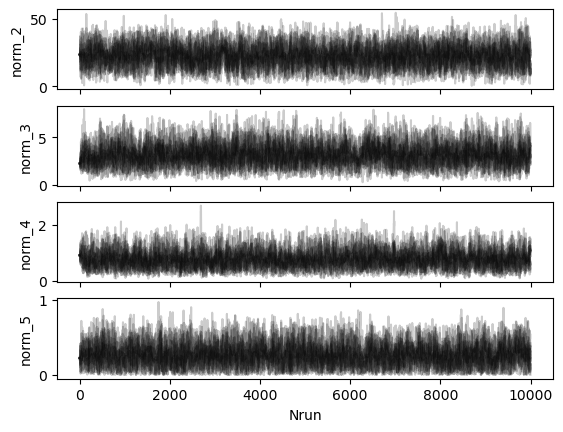

In [23]:
plot_trace(sampler, dataset00)

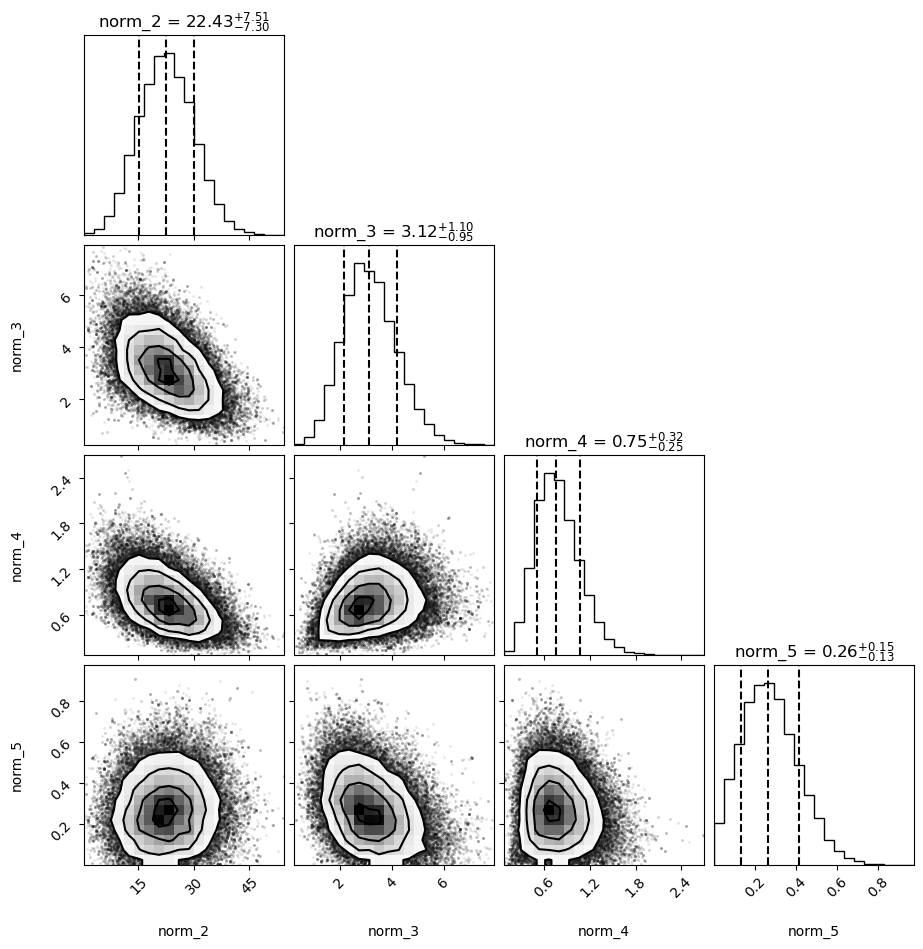

In [24]:
nburn = 1000
plot_corner(sampler, dataset00, nburn)

### SED points
+ `get_dnde(sampler, dataset, nburn)`

In [28]:
dnde_arr, dnde_err_minus_arr, dnde_err_plus_arr = get_dnde(sampler, dataset00, nburn)

In [29]:
print("dnde: ", dnde_arr)
print("\n dnde_err_minus", dnde_err_minus_arr)
print("\n dnde_err_plus", dnde_err_plus_arr)

print("e2dnde: ", dnde_arr * true_ene_cntr.to(u.TeV)**2)
print("\n e2dnde_err_minus", dnde_err_minus_arr * true_ene_cntr.to(u.TeV)**2)
print("\n e2dnde_err_plus", dnde_err_plus_arr * true_ene_cntr.to(u.TeV)**2)

dnde:  [0.00000000e+00 0.00000000e+00 2.57527098e-07 1.48825241e-08
 1.48821135e-09 2.17844153e-10 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00] 1 / (TeV s cm2)

 dnde_err_minus [0.00000000e+00 0.00000000e+00 8.37866648e-08 4.53957838e-09
 5.03917466e-10 1.07431215e-10 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00] 1 / (TeV s cm2)

 dnde_err_plus [0.00000000e+00 0.00000000e+00 8.62064522e-08 5.26548104e-09
 6.27426210e-10 1.24429294e-10 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.0000000

[]

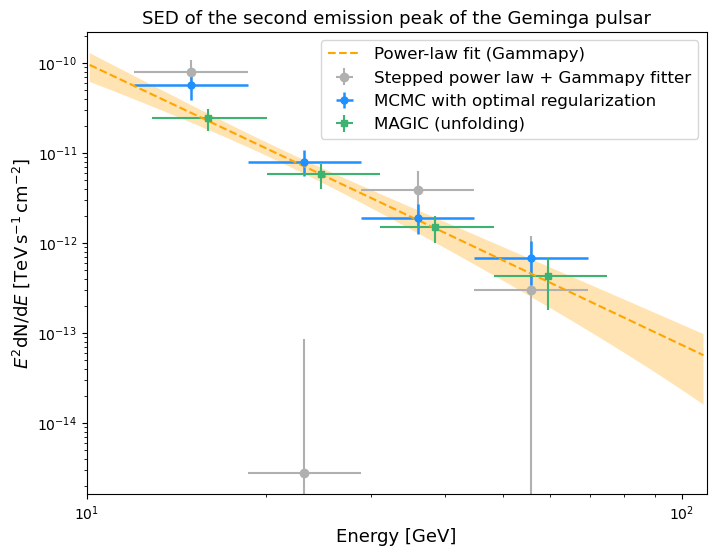

In [30]:
#SED
fig, ax = plt.subplots(figsize=(8, 6))
energy_bounds = [10, 110] # * u.GeV
plot_kwargs = {
    "energy_bounds": [10, 110] * u.GeV,
    "sed_type": "e2dnde",
    "yunits": u.Unit("TeV cm-2 s-1"),
    "ax": ax,
}

plt.errorbar(true_ene_cntr, dnde_arr_fit * true_ene_cntr.to(u.TeV)**2, xerr=[ene_err_lower, ene_err_upper], yerr=dnde_error_arr_fit * true_ene_cntr.to(u.TeV)**2, fmt='o', color='#B0B0B0', label='Stepped power law + Gammapy fitter')

plt.errorbar(true_ene_cntr, dnde_arr * true_ene_cntr.to(u.TeV)**2, 
             xerr=[ene_err_lower, ene_err_upper], 
            yerr=[dnde_err_minus_arr * true_ene_cntr.to(u.TeV)**2, dnde_err_plus_arr * true_ene_cntr.to(u.TeV)**2], 
             capsize=0, elinewidth=1.8, fmt='o', color='dodgerblue', markersize=5, label="MCMC with optimal regularization")


plt.errorbar(E_mid, SED, xerr=E_err, yerr=SED_err, capsize=0, fmt='s', color='mediumseagreen', markersize=4, label='MAGIC (unfolding)')

model_pwl.spectral_model.plot(**plot_kwargs, color='orange',ls='--',label="Power-law fit (Gammapy)")
model_pwl.spectral_model.plot_error(**plot_kwargs, facecolor="orange", alpha=0.3)

ax.set_xlim(energy_bounds)
ax.set_xlabel("Energy [GeV]", fontsize=13)
ax.set_ylabel(r"$E^2$dN/d$E$ $\mathrm{[TeV \, s^{-1} \, cm^{-2}]}$", fontsize=13)
plt.title('SED of the second emission peak of the Geminga pulsar', fontsize=13)
plt.legend(fontsize=12)
plt.loglog()

### Correlation matrix between the spectral points

In [31]:
free_param = dataset00.models.parameters.free_parameters
labels = [par.name for par in free_param]

flat_samples = sampler.get_chain(discard=nburn, flat=True).T
flat_samples_rescale = np.zeros_like(flat_samples)

for i, par in enumerate(free_param):
    flat_samples_rescale[i, :] = flat_samples[i,:] * par.scale

# covariance matrix
cov_param = np.cov(flat_samples_rescale)
cov_param

array([[ 5.37409087e+01, -3.68534228e+00, -1.03094347e+00,
         5.08137273e-02],
       [-3.68534228e+00,  1.06703976e+00,  7.05192769e-02,
        -4.49519698e-02],
       [-1.03094347e+00,  7.05192769e-02,  8.30949252e-02,
        -3.82088978e-03],
       [ 5.08137273e-02, -4.49519698e-02, -3.82088978e-03,
         1.90658525e-02]])

([<matplotlib.axis.YTick at 0x7f2c37dd5060>,
 [Text(0, 0, 'norm_2'),
  Text(0, 1, 'norm_3'),
  Text(0, 2, 'norm_4'),
  Text(0, 3, 'norm_5')])

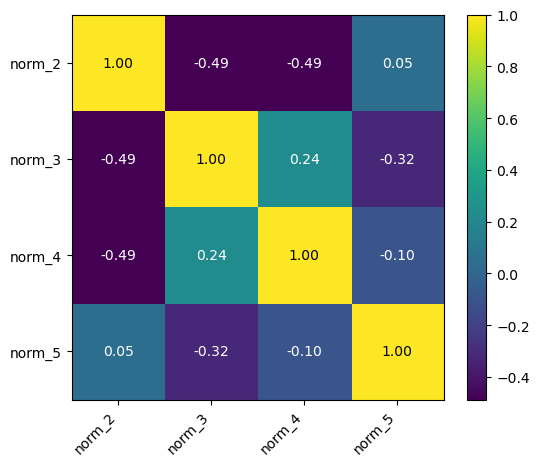

In [32]:
# correlation matrix
std = np.sqrt(np.diag(cov_param))

correlation_matrix = cov_param / np.outer(std, std)

plt.figure(figsize=(6,5))
heatmap = plt.imshow(correlation_matrix, cmap='viridis', interpolation='none', aspect='auto')
plt.colorbar(heatmap)

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i==j:
            plt.text(j, i, f'{correlation_matrix[i, j]:.2f}', ha='center', va='center', color='black')
        else:
            plt.text(j, i, f'{correlation_matrix[i, j]:.2f}', ha='center', va='center', color='white')

plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(labels)), labels=labels)